In [292]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

## Questions to Answer

1. What is the chance of experiencing a moderate to severe earthquake in my region?
2. What is the chance of experiencing an earthquake of any magnitude over a given timeframe?
3. How evenly distributed are earquake occurrences over time?

In [293]:
# Data obtained from from https://www.ngdc.noaa.gov/hazard/eq-intensity.shtml

quakes = pd.read_excel('eqint_tsqp.xls')

In [294]:
quakes.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LOCAL_TO_UTC,UNPUB_OR_GROUPED_INT,LATITUDE,LONGITUDE,MAGNITUDE,EQ_DEPTH,EPIDIST,CITY_LAT,CITY_LON,MMI,STATE,CITY,SOURCE,COUNTRY
0,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,0.0,34.50,-119.00,7.0,CA,LOCKWOOD VALLEY,H,USA
1,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,258.0,33.02,-116.84,6.0,CA,SAN DIEGO,H,USA
2,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,159.0,35.35,-120.41,6.0,CA,SAN LUIS OBISPO,H,USA
3,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,NaN,NaN,NaN,6.0,CA,COLORADO RIVER,H,USA
4,1860,11.0,12.0,NaN,NaN,NaN,8.0,NaN,41.0,-124.0,NaN,NaN,32.0,40.76,-124.22,8.0,CA,HUMBOLDT BAY,H,USA


In [351]:
# Narrow earthquakes down to a specific region (NC), and select relevant columns
# Create unique day index

NC_quakes = quakes[quakes['STATE']=='NC']
df = NC_quakes[['YEAR','MONTH','DAY','MMI','STATE']]
df['Unique_Day'] = pd.to_datetime(NC_quakes.loc[:,['YEAR','MONTH','DAY']])

C:\Users\bradp\anaconda3\envs\geo_map\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [352]:
# Use MMI scale to create reverse dictionary to match earthquake MMI with description of intensity.

quake_class = {'Not Felt': [1], 'Weak':[2,3], 'Light': [4], 'Moderate': [5], 'Strong':[6], 'Very Strong': [7], 'Severe': [8], 'Violent': [9], 'Extreme': [10]}

# Look up description based on MMI
quake_dict = {}

for k,v in quake_class.items():
    for n in v:
        quake_dict[n] = k
quake_class_df['Intensity'] = pd.DataFrame([quake_dict]).T

quake_class_df

,Intensity
1,Not Felt
2,Weak
3,Weak
4,Light
5,Moderate
6,Strong
7,Very Strong
8,Severe
9,Violent
10,Extreme


In [297]:
# Get maximum earthquake intensity that occurred on a single day. Different reportings of lower MMI on the same day are considered to be the same quake.

max_quakes = df.groupby('Unique_Day').max().dropna()
max_quakes[['Decade']] = (np.round(max_quakes['YEAR']/10)*10).astype(int)
max_quakes.head()

,YEAR,MONTH,DAY,MMI,STATE,Decade
Unique_Day,,,,,,
1811-12-16,1811,12.0,16.0,4.0,NC,1810
1812-01-23,1812,1.0,23.0,2.0,NC,1810
1828-03-10,1828,3.0,10.0,5.0,NC,1830
1833-08-27,1833,8.0,27.0,3.0,NC,1830
1843-01-05,1843,1.0,5.0,4.0,NC,1840


In [298]:
# Merge dataframe on column MMI with description of earthquake intensities

df = pd.merge(max_quakes, quake_class_df, left_on='MMI', right_index=True)
df.head()

,YEAR,MONTH,DAY,MMI,STATE,Decade,Intensity
Unique_Day,,,,,,,
1811-12-16,1811,12.0,16.0,4.0,NC,1810,Light
1843-01-05,1843,1.0,5.0,4.0,NC,1840,Light
1898-11-25,1898,11.0,25.0,4.0,NC,1900,Light
1913-04-17,1913,4.0,17.0,4.0,NC,1910,Light
1950-06-19,1950,6.0,19.0,4.0,NC,1950,Light


## Radial Chart

In [299]:
import plotly.express as px
import pandas as pd

counts = df['Intensity'].value_counts()
fig = px.line_polar(counts, r =counts, theta=counts.index, line_close=True)
fig.show()

#source: https://plotly.com/python/radar-chart/

## Stacked Area Chart

In [300]:
# Get number of earthquakes of each intensity category occurring in each decade

decade_df = pd.pivot_table(df, values='MMI', index='Decade', columns='Intensity', aggfunc='count', fill_value=0)

# Rearrange columns
decade_df = decade_df[['Weak','Light','Moderate','Strong','Severe']]

In [354]:
# Get cumulative number of earthquakes since beginning of dataset

cumm_decade_df = decade_df.cumsum()
cumm_decade_df.head(15)

Intensity,Weak,Light,Moderate,Strong,Severe
Decade,,,,,
1810,1,1,0,0,0
1830,2,1,1,0,0
1840,3,2,1,0,0
1850,4,2,1,0,0
1860,4,2,1,1,0
1870,4,2,7,1,0
1880,4,2,11,2,0
1890,4,2,11,2,1
1900,8,3,11,2,1


Text(0.5, 1.0, 'Number of Earthquakes in North Carolina each Decade since 1810')

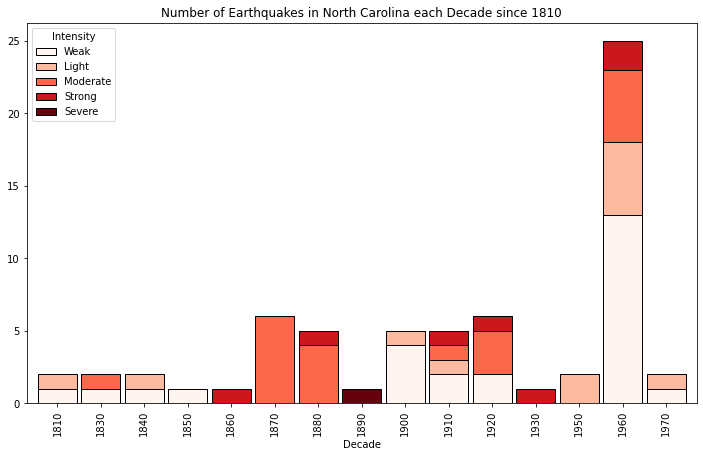

In [366]:
# Get earthquakes per decade of each intensity rating

decade_df.plot.bar(figsize=(12,7), width=0.9, colormap='Reds', edgecolor='black', stacked=True)

plt.title('Number of Earthquakes in North Carolina each Decade since 1810')


Text(0.5, 1.0, 'Cumulative Number of Earthquakes in North Carolina since 1810')

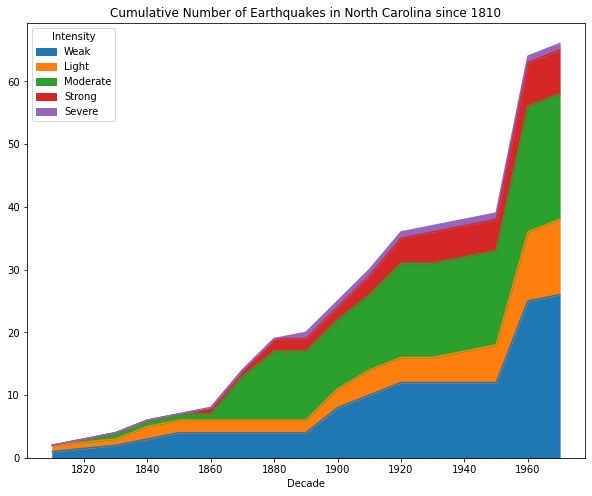

In [319]:
# Get cummulative earthquakes since beginning of data set

cumm_decade_df.plot.area(figsize=(10,8))
plt.title('Cumulative Number of Earthquakes in North Carolina since 1810')


# Conclusions

1. Most earthquakes are weak to moderate, but strong to severe occur occasionally.
2. There are typically around 5 earthquakes per decade if light and weak quakes are included.
3. 1960s had an unusual number of earthquakes.
